# Predictive Pipeline for Foliar Nutrient Estimation - Fresh Seasons

## 1. Correlation Analysis

In [3]:
import warnings
warnings.filterwarnings('ignore')

Top-2 correlated nutrients for N: Zn (r=0.787), Ca (r=0.685)
Top-2 correlated nutrients for P: S (r=0.915), Zn (r=0.085)
Top-2 correlated nutrients for K: Zn (r=0.880), Cu (r=0.702)
Top-2 correlated nutrients for B: Ca (r=0.656), Mg (r=0.512)
Top-2 correlated nutrients for Mn: Ca (r=0.646), Zn (r=0.612)


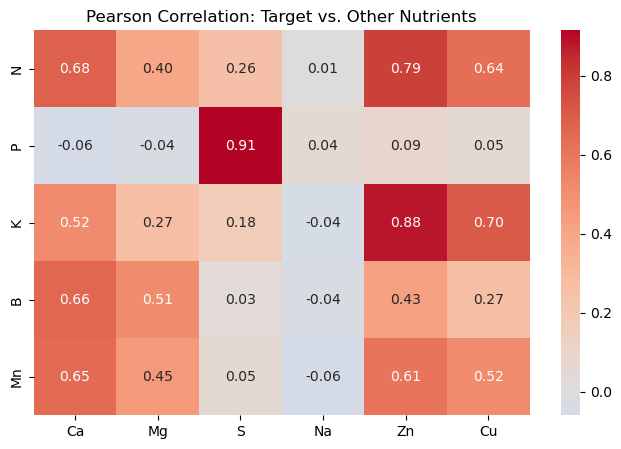

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Nutrient target and feature lists
target_nutrients = ["N", "P", "K", "B", "Mn"]
# All measured nutrients (from dataset description, excluding Cl which is dropped)
all_nutrients = ["N","P","K","Ca","Mg","S","Mn","B","Na","Zn","Fe","Cu"]

# Load datasets for three seasons
df1 = pd.read_csv("FRESH_season01_cleaneddata.csv")
df2 = pd.read_csv("FRESH_season02.csv")
df3 = pd.read_csv("FRESH_season03_filleddata.xls")

# Unify nutrient column names across seasons
col_map = {
    "Nitrogen":"N", "N":"N",
    "Phosphorous":"P", "Phosphorus":"P", "P":"P",
    "Potassium":"K", "K":"K",
    "Calcium":"Ca", "Ca":"Ca",
    "Magnesium":"Mg", "Mg":"Mg",
    "Sulfur":"S", "Sulphur":"S", "S":"S",
    "Manganese":"Mn", "Mn":"Mn",
    "Boron":"B", "B":"B",
    "Sodium":"Na", "Na":"Na",
    "Zinc":"Zn", "Zn":"Zn",
    "Copper":"Cu", "Cu":"Cu",
    
}

all_nutrients = ["N","P","K","Ca","Mg","S","Mn","B","Na","Zn","Cu"]

def unify_columns(df):
    df = df.rename(columns={col: col_map.get(col, col) for col in df.columns})
    return df

df1 = unify_columns(df1) 
df2 = unify_columns(df2)
df3 = unify_columns(df3) 

# Combine all nutrient data (excluding reflectance columns) for correlation analysis
nutrient_df1 = df1[all_nutrients]
nutrient_df2 = df2[all_nutrients]
nutrient_df3 = df3[all_nutrients] 
all_nutrient_data = pd.concat([nutrient_df1, nutrient_df2, nutrient_df3], ignore_index=True)

# Compute Pearson correlation matrix
corr_matrix = all_nutrient_data.corr()

# Extract correlations of targets vs other nutrients (micronutrients/others)
other_nutrients = [nut for nut in all_nutrients if nut not in target_nutrients]
corr_target_vs_micro = corr_matrix.loc[target_nutrients, other_nutrients]

# Identify top-2 correlated nutrients (by absolute Pearson r) for each target
top2_micros = {}
for target in target_nutrients:
    # Sort other nutrients by absolute correlation with this target
    corr_series = corr_target_vs_micro.loc[target]
    top2 = corr_series.reindex(other_nutrients).abs().sort_values(ascending=False).index[:2].tolist()
    top2_micros[target] = top2
    print(f"Top-2 correlated nutrients for {target}: {top2[0]} (r={corr_series[top2[0]]:.3f}), "
          f"{top2[1]} (r={corr_series[top2[1]]:.3f})")

# Plot correlation heatmap for targets vs other nutrients
plt.figure(figsize=(8,5))
sns.heatmap(corr_target_vs_micro, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Pearson Correlation: Target vs. Other Nutrients")
plt.show()

## 2. Spectral Feature Engineering

In [6]:
# Define 8nm bins from 400nm to 2500nm
bin_ranges = []
start = 400.0
while start < 2500.0:
    end = min(start + 7.5, 2500.0)  # each bin ~8nm wide, last bin may be <8nm
    bin_ranges.append((start, end))
    start += 8.0

# Function to bin spectral reflectance columns (0.5nm or 1nm resolution) into the defined 8nm ranges
def bin_reflectance(df):
    # Identify reflectance columns by 'nm' suffix
    reflect_cols = [c for c in df.columns if c.endswith("nm")]
    reflect_wavelengths = np.array([float(c.replace("nm","")) for c in reflect_cols])
    binned_data = {}
    for start, end in bin_ranges:
        # columns within [start, end] range
        mask = (reflect_wavelengths >= start) & (reflect_wavelengths <= end)
        cols_in_bin = [reflect_cols[i] for i, m in enumerate(mask) if m]
        if cols_in_bin:
            binned_data[f"{start:.1f}-{end:.1f}nm"] = df[cols_in_bin].mean(axis=1)
        else:
            # if no measurement in this bin (should not happen for defined ranges)
            binned_data[f"{start:.1f}-{end:.1f}nm"] = np.nan
    # Combine nutrient columns with new binned reflectance features
    return pd.concat([df[all_nutrients].reset_index(drop=True), pd.DataFrame(binned_data)], axis=1)

# Apply binning to each season dataset
df1_binned = bin_reflectance(df1)
df2_binned = bin_reflectance(df2)
df3_binned = bin_reflectance(df3)

print("Binned feature count:", df1_binned.shape[1]-len(all_nutrients), "spectral features per sample")
# Example: show first 5 binned feature names
print("Sample binned wavelength ranges:", list(df1_binned.columns[len(all_nutrients):len(all_nutrients)+5]))

Binned feature count: 263 spectral features per sample
Sample binned wavelength ranges: ['400.0-407.5nm', '408.0-415.5nm', '416.0-423.5nm', '424.0-431.5nm', '432.0-439.5nm']


## 3. Micronutrient Prediction (PLS Regression)

In [8]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

# Determine the unique set of micronutrients to predict (union of all targets' top-2)
micronutrients_to_predict = sorted({mic for micros in top2_micros.values() for mic in micros})
print("Micronutrients to predict from spectra:", micronutrients_to_predict)

def train_pls_for_micros(X_train, y_train, X_test):
    """
    Train PLS regression models to predict each micronutrient in micronutrients_to_predict from spectral data.
    Returns DataFrames of predicted micronutrient values for train and test sets.
    """
    train_pred = pd.DataFrame(index=X_train.index)
    test_pred = pd.DataFrame(index=X_test.index)
    for micro in micronutrients_to_predict:
        # Extract training labels for this micronutrient
        y = y_train[micro]
        # Tune number of PLS components via 5-fold CV (trying 5, 8, 10, 15, 20)
        best_components = None
        best_r2 = -np.inf
        for n_comp in [2,36,70,103,137,171,205,260]:
            pls = PLSRegression(n_components=n_comp, scale=True)
            cv_scores = cross_val_score(pls, X_train, y, cv=5, scoring='r2')
            if cv_scores.mean() > best_r2:
                best_r2 = cv_scores.mean()
                best_components = n_comp
        # Train PLS with best_components on full training data
        pls_final = PLSRegression(n_components=best_components, scale=True)
        # Obtain out-of-fold predictions on training data for stacking
        train_pred[f"{micro}_pred"] = cross_val_predict(pls_final, X_train, y, cv=5)
        # Fit on full train and predict test set
        pls_final.fit(X_train, y)
        test_pred[f"{micro}_pred"] = pls_final.predict(X_test).ravel()
        print(f"Trained PLS for {micro} with {best_components} components (CV R²={best_r2:.3f})")
    return train_pred, test_pred

# Example: Train PLS models for micros on Season2 train data and predict Season2 test
# (Season2 train/test will be used in Stage 1 of transfer learning below)
X2_train_spec = df2_binned.drop(columns=all_nutrients)
X2_test_spec  = df2_binned.drop(columns=all_nutrients)  # here using full df2 for illustration; actual pipeline uses splits
y2_train = df2_binned[all_nutrients]
train_micros_pred, test_micros_pred = train_pls_for_micros(X2_train_spec, y2_train, X2_test_spec)
print(train_micros_pred.head(3))

Micronutrients to predict from spectra: ['Ca', 'Cu', 'Mg', 'S', 'Zn']
Trained PLS for Ca with 2 components (CV R²=-1.114)
Trained PLS for Cu with 2 components (CV R²=-1.083)
Trained PLS for Mg with 36 components (CV R²=-0.892)
Trained PLS for S with 2 components (CV R²=-1.016)
Trained PLS for Zn with 2 components (CV R²=-0.453)
    Ca_pred   Cu_pred   Mg_pred    S_pred    Zn_pred
0  1.898156  6.770076  0.681269  0.215556  40.188985
1  1.871777  6.146318  0.742571  0.220473  41.542318
2  1.865675  5.549063  0.503615  0.220894  42.354590


## 4. Model Selection with FLAML (AutoML)

FRESH_season01_cleaneddata.csv: X_tr (20, 263), X_te (20, 263), y_tr (20, 11), y_te (20, 11)
FRESH_season02.csv: X_tr (72, 263), X_te (72, 263), y_tr (72, 11), y_te (72, 11)
FRESH_season03_filleddata.xls: X_tr (52, 263), X_te (53, 263), y_tr (52, 11), y_te (53, 11)
X_train_full_spec: (144, 263)
y_train_full:       (144, 11)
X_test_full_spec:  (145, 263)
y_test_full:        (145, 11)
Trained PLS for Ca with 2 components (CV R²=-0.906)
Trained PLS for Cu with 2 components (CV R²=-4.017)
Trained PLS for Mg with 2 components (CV R²=-0.360)
Trained PLS for S with 2 components (CV R²=-7.459)
Trained PLS for Zn with 2 components (CV R²=-215.880)
N svr -> R²=0.633, NRMSE=62.97%, RPD=1.65
N rf -> R²=0.650, NRMSE=61.45%, RPD=1.69
N lgbm -> R²=0.809, NRMSE=45.38%, RPD=2.29

[N] Best model based on test R²: lgbm with config: {'n_estimators': 26, 'num_leaves': 10, 'min_child_samples': 19, 'learning_rate': 0.297942247515257, 'log_max_bin': 7, 'colsample_bytree': 0.8332275411263533, 'reg_alpha': 0.07

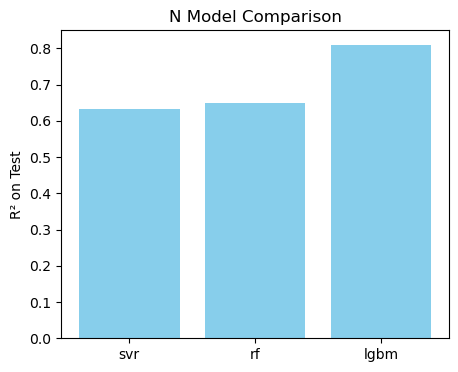

P svr -> R²=-0.315, NRMSE=488.98%, RPD=0.87
P rf -> R²=-0.044, NRMSE=435.72%, RPD=0.98
P lgbm -> R²=-0.061, NRMSE=439.26%, RPD=0.97

[P] Best model based on test R²: rf with config: {'n_estimators': 6, 'max_features': 0.7608449210530499, 'max_leaves': 5}


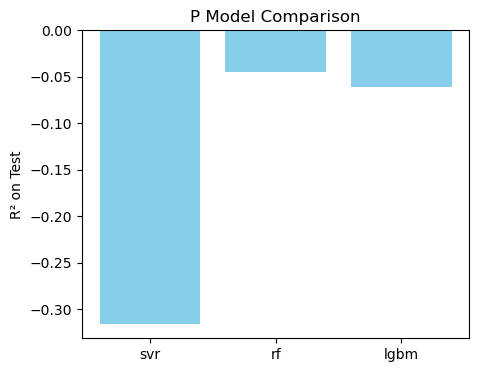

K svr -> R²=0.462, NRMSE=80.79%, RPD=1.36
K rf -> R²=0.740, NRMSE=56.17%, RPD=1.96
K lgbm -> R²=0.845, NRMSE=43.43%, RPD=2.54

[K] Best model based on test R²: lgbm with config: {'n_estimators': 52, 'num_leaves': 7, 'min_child_samples': 7, 'learning_rate': 0.06401075674244511, 'log_max_bin': 7, 'colsample_bytree': 0.6631552523046633, 'reg_alpha': 0.3884901213209612, 'reg_lambda': 0.1504998754345849}


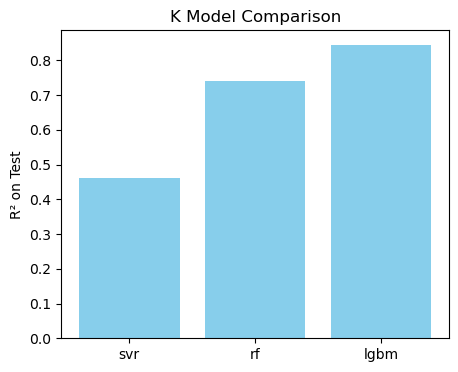

B svr -> R²=0.271, NRMSE=124.41%, RPD=1.17
B rf -> R²=0.593, NRMSE=92.97%, RPD=1.57
B lgbm -> R²=0.483, NRMSE=104.78%, RPD=1.39

[B] Best model based on test R²: rf with config: {'n_estimators': 12, 'max_leaves': 5, 'max_features': 0.4818288650888014}


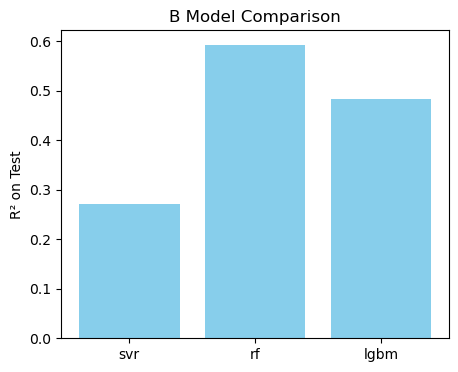

Mn svr -> R²=0.374, NRMSE=103.06%, RPD=1.26
Mn rf -> R²=0.446, NRMSE=97.01%, RPD=1.34
Mn lgbm -> R²=0.634, NRMSE=78.81%, RPD=1.65

[Mn] Best model based on test R²: lgbm with config: {'n_estimators': 34, 'num_leaves': 9, 'min_child_samples': 11, 'learning_rate': 0.0814121045306094, 'log_max_bin': 8, 'colsample_bytree': 0.6010397097739608, 'reg_alpha': 7.832634016250592, 'reg_lambda': 0.010803690255861963}


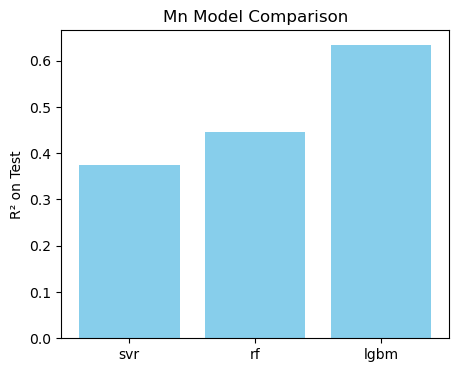

In [14]:
from flaml import AutoML, tune
from flaml.model import SKLearnEstimator
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

# Define a custom estimator class for SVR to use in FLAML
class SVREstimator(SKLearnEstimator):
    def __init__(self, task="regression", **config):
        config.pop("n_jobs", None)
        super().__init__(task, **config)
        self.estimator_class = SVR
    @classmethod
    def search_space(cls, data_size, task):
        return {
            "C":      {"domain": tune.loguniform(1e-2, 1e2)},
            "kernel": {"domain": tune.choice(["linear","rbf","poly"])},
            "gamma":  {"domain": tune.loguniform(1e-4,1e-1)},
        }

# Define season keys in the same order as your variables
season_keys = [
    "FRESH_season01_cleaneddata.csv",
    "FRESH_season02.csv",
    "FRESH_season03_filleddata.xls"
]

# Build splits dict from each df*_binned
#    (assumes you have df1_binned, df2_binned, df3_binned already defined)
splits = {}
for season, df_binned in zip(season_keys, [df1_binned, df2_binned, df3_binned]):
    X = df_binned.drop(columns=all_nutrients)
    y = df_binned[all_nutrients]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)
    splits[season] = (X_tr, X_te, y_tr, y_te)

# Sanity check
for s in season_keys:
    X_tr, X_te, y_tr, y_te = splits[s]
    print(f"{s}: X_tr {X_tr.shape}, X_te {X_te.shape}, y_tr {y_tr.shape}, y_te {y_te.shape}")

# Build the “full” train/test sets by concatenating from splits
X_train_full_spec = pd.concat([splits[s][0] for s in season_keys], ignore_index=True)
X_test_full_spec  = pd.concat([splits[s][1] for s in season_keys], ignore_index=True)

y_train_full = pd.concat([splits[s][2] for s in season_keys], ignore_index=True)
y_test_full  = pd.concat([splits[s][3] for s in season_keys], ignore_index=True)

# Quick sanity check
print("X_train_full_spec:", X_train_full_spec.shape)
print("y_train_full:      ", y_train_full.shape)
print("X_test_full_spec: ", X_test_full_spec.shape)
print("y_test_full:       ", y_test_full.shape)

# Generate micronutrient predictions on the full sets
micros_train_pred, micros_test_pred = train_pls_for_micros(X_train_full_spec, y_train_full, X_test_full_spec)

# Iterate over each target nutrient and run AutoML
model_performance = {}  # to store performance metrics for each model type per nutrient
for target in target_nutrients:
    # Prepare final feature matrices for this target: [PLS spectral components + predicted micros]
    y_train = y_train_full[target].values
    y_test = y_test_full[target].values
    # Perform a final PLS on spectral data to reduce dimensionality (using tuned components from earlier if available)
    pls = PLSRegression(n_components=30, scale=True).fit(X_train_full_spec, y_train)
    X_train_pls = pls.transform(X_train_full_spec)
    X_test_pls = pls.transform(X_test_full_spec)
    # Concatenate PLS components with predicted micro features
    X_train_final = np.hstack([X_train_pls, micros_train_pred.values])
    X_test_final = np.hstack([X_test_pls, micros_test_pred.values])
    
    # Set up and run FLAML AutoML for model selection
    automl = AutoML()
    automl.add_learner('svr', SVREstimator)  # register custom SVR
    automl_settings = {
        "time_budget": 60,            # seconds
        "task": "regression",
        "estimator_list": ["svr", "rf", "lgbm"],
        "metric": 'r2',              # maximize R²
        "log_file_name": f"{target}_automl.log",
        "verbose": 0,
        "seed": 42
    }
    automl.fit(X_train_final, y_train, **automl_settings)
    
    # Evaluate all candidate models on test set for comparison
    model_performance[target] = {}
    best_r2 = -float('inf')
    best_estimator_name = None
    best_config = None
    # Retrieve best hyperparams for each estimator tried
    for estimator_name, config in automl.best_config_per_estimator.items():
        if config is None:  # Skip if no valid configuration found
            print(f"Skipping {estimator_name} due to no valid configuration")
            continue
        # Initialize model with best found hyperparams
        if estimator_name == 'svr':
            model = SVR(**{k:v for k,v in config.items() if k not in ['learner']})
        elif estimator_name == 'rf':
            # Instantiate a dummy RF to see which params it supports
            dummy = RandomForestRegressor()
            # Keep only keys that RF accepts
            allowed = dummy.get_params().keys()
            rf_config = {k: v for k, v in config.items() if k in allowed}
            model = RandomForestRegressor(**rf_config)
        elif estimator_name == 'lgbm':
            dummy = LGBMRegressor()
            allowed = dummy.get_params().keys()
            lgbm_config = {k: v for k, v in config.items() if k in allowed}
            model = LGBMRegressor(**lgbm_config)
        else:
            continue
        # Train on full training data and evaluate on test
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        nrmse = rmse / np.mean(y_test) * 100
        rpd = np.std(y_test) / rmse
        model_performance[target][estimator_name] = {"R2": r2, "NRMSE": nrmse, "RPD": rpd}
        print(f"{target} {estimator_name} -> R²={r2:.3f}, NRMSE={nrmse:.2f}%, RPD={rpd:.2f}")
        # Track the best model based on test R²
        if r2 > best_r2:
            best_r2 = r2
            best_estimator_name = estimator_name
            best_config = config

    # Print the model with the highest test R²
    print(f"\n[{target}] Best model based on test R²: {best_estimator_name} with config: {best_config}")
    
    # Plot R² comparison for this nutrient
    models = list(model_performance[target].keys())
    r2_values = [model_performance[target][m]["R2"] for m in models]
    plt.figure(figsize=(5,4))
    plt.bar(models, r2_values, color='skyblue')
    plt.ylabel("R² on Test")
    plt.title(f"{target} Model Comparison")
    plt.show()

## 5. Stacking Ensemble Model

In [24]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin

# Use the full combined dataset for training and testing
X_train = X_train_full_spec  # spectral features for all training samples (all seasons combined)
y_train = y_train_full[target_nutrients]  # target nutrients (N, P, K, B, Mn) for all training samples
X_test  = X_test_full_spec   # spectral features for all test samples (all seasons combined)
y_test  = y_test_full[target_nutrients]   # target nutrients for all test samples

# Custom wrapper to train a regressor on a subset of output columns
class MultiOutputSubsetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator, target_names):
        self.estimator = estimator
        self.target_names = target_names

    def fit(self, X, y):
        # If y is a DataFrame, select by column names
        if hasattr(y, "loc"):
            y_subset = y[self.target_names]
        else:
            y_arr = np.asarray(y)
            # If 1‑D array, it's already a single target
            if y_arr.ndim == 1:
                y_subset = y_arr
            else:
                # y is 2‑D numpy: pick the desired columns by index
                idxs = [target_nutrients.index(name) for name in self.target_names]
                y_subset = y_arr[:, idxs]
        self.estimator.fit(X, y_subset)
        return self

    def predict(self, X):
        return self.estimator.predict(X)


# Define base learners using the best model type for each nutrient (with each model handling its subset of targets)
base_learners = [
    ("rf_PB", MultiOutputSubsetRegressor(RandomForestRegressor(n_estimators=100, random_state=42), ["P","B"])),
    ("lgb_NKMn",  MultiOutputSubsetRegressor(LGBMRegressor(random_state=42), ["N","K","Mn"])),
    #("svr_", MultiOutputSubsetRegressor(SVR(), []))
]

# base_learners is your list of (name, estimator) tuples
base_stack = StackingRegressor(estimators=base_learners, final_estimator=Ridge(alpha=1.0), cv=5)

# Wrap in MultiOutputRegressor and initialize the stacking ensemble with Ridge as meta-learner
stacking_model = MultiOutputRegressor(base_stack)

# Now this will accept y_train of shape (n_samples, 5)
stacking_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=StackingRegressor(cv=5,
                                                 estimators=[('rf_PB',
                                                              MultiOutputSubsetRegressor(estimator=RandomForestRegressor(random_state=42),
                                                                                         target_names=['P',
                                                                                                       'B'])),
                                                             ('lgb_NKMn',
                                                              MultiOutputSubsetRegressor(estimator=LGBMRegressor(random_state=42),
                                                                                         target_names=['N',
                                                                                                       'K',
                                                                                                       'Mn']))],
                                                 final_estimator=Ridge()))

In [25]:
# 1) Get predictions on your hold‑out test set
# Assuming stacking_model is your fitted MultiOutputRegressor
y_pred = stacking_model.predict(X_test)

# 2) Compute metrics for each nutrient
results = []
for i, nut in enumerate(target_nutrients):
    y_true = y_test[nut].values
    y_hat  = y_pred[:, i]
    r2   = r2_score(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat, squared=False)
    nrmse = rmse / y_true.std()         # or divide by (max−min)
    rpd   = y_true.std() / rmse
    results.append({
        "nutrient": nut,
        "R²":       r2,
        "RMSE":     rmse,
        "NRMSE":    nrmse,
        "RPD":      rpd
    })

# 3) Display as a DataFrame
metrics_df = pd.DataFrame(results).set_index("nutrient")
print(metrics_df.round(3))

             R²     RMSE  NRMSE    RPD
nutrient                              
N         0.824    0.825  0.420  2.381
P        -0.023    0.653  1.012  0.989
K         0.841    1.505  0.399  2.507
B         0.611   23.546  0.624  1.603
Mn        0.698  174.788  0.550  1.818


## 6. Transfer Learning Across Seasons

In [27]:
# For each season, combine X_tr & y_tr into dfX_train, and X_te & y_te into dfX_test
df1_train = pd.concat([splits[season_keys[0]][0], splits[season_keys[0]][2]], axis=1)
df1_test  = pd.concat([splits[season_keys[0]][1], splits[season_keys[0]][3]], axis=1)

df2_train = pd.concat([splits[season_keys[1]][0], splits[season_keys[1]][2]], axis=1)
df2_test  = pd.concat([splits[season_keys[1]][1], splits[season_keys[1]][3]], axis=1)

df3_train = pd.concat([splits[season_keys[2]][0], splits[season_keys[2]][2]], axis=1)
df3_test  = pd.concat([splits[season_keys[2]][1], splits[season_keys[2]][3]], axis=1)

print("df1_train:", df1_train.shape, "df1_test:", df1_test.shape)
print("df2_train:", df2_train.shape, "df2_test:", df2_test.shape)
print("df3_train:", df3_train.shape, "df3_test:", df3_test.shape)

df1_train: (20, 274) df1_test: (20, 274)
df2_train: (72, 274) df2_test: (72, 274)
df3_train: (52, 274) df3_test: (53, 274)


In [28]:
from sklearn.linear_model import Ridge

# Re‑use train_predict_micros(...) and your binned_dfs & splits from before

# 1) Define the transfer stages
train_stage = {
    "Season2":              df2_train,
    "Season2+3":            pd.concat([df2_train, df3_train], ignore_index=True),
    "Season2+3+1":          pd.concat([df2_train, df3_train, df1_train], ignore_index=True),
}
test_stage = {
    "Season2":              df2_test,
    "Season2+3":            pd.concat([df2_test, df3_test], ignore_index=True),
    "Season2+3+1":          pd.concat([df2_test, df3_test, df1_test], ignore_index=True),
}

# 2) Metric function
def evaluate_metrics(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nrmse= (rmse / np.mean(y_true)) * 100
    rpd  = np.std(y_true) / rmse
    return r2, nrmse, rpd
    
# 3) Transfer‑learning loop    
performance_records = []
for stage in train_stage:
    train_df = train_stage[stage]
    test_df  = test_stage[stage]
    
    print(f"\n>>> Stage: {stage}")
    
    # Split out spectra vs nutrients
    X_tr_spec = train_df.drop(columns=all_nutrients)
    X_te_spec = test_df .drop(columns=all_nutrients)
    y_tr_all  = train_df[ all_nutrients ]
    y_te_all  = test_df[ all_nutrients ]
    
    # 3a) Predict micros on this stage
    micros_tr, micros_te = train_pls_for_micros(X_tr_spec, y_tr_all, X_te_spec)
    
    # 3b) For each target nutrient, do manual stacking
    for nut in target_nutrients:
        y_tr = y_tr_all[nut].values
        y_te = y_te_all[nut].values
        
        # -- choose PLS components (you can reuse a fixed value or re‑tune here) --
        best_r2, best_k = -np.inf, None
        for k in [5,10,15,20]:
            pls0 = PLSRegression(n_components=k, scale=True)
            cv_r2 = cross_val_score(pls0, X_tr_spec, y_tr, cv=3, scoring="r2").mean()
            if cv_r2 > best_r2:
                best_r2, best_k = cv_r2, k
        pls = PLSRegression(n_components=best_k, scale=True).fit(X_tr_spec, y_tr)
        
        # -- Base1: PLS→RF --
        X_tr_lat = pls.transform(X_tr_spec)
        X_te_lat = pls.transform(X_te_spec)
        base1 = RandomForestRegressor(n_estimators=100, random_state=40)
        base1.fit(X_tr_lat, y_tr)
        
        # -- Base2: Ridge on micros --
        base2 = Ridge(alpha=1.0)
        base2.fit(micros_tr.values, y_tr)
        
        # -- Meta: Ridge on base predictions --
        # Gather base predictions on train
        p1_tr = base1.predict(X_tr_lat)
        p2_tr = base2.predict(micros_tr.values)
        X_meta_tr = np.vstack([p1_tr, p2_tr]).T
        
        meta = Ridge(alpha=1.0)
        meta.fit(X_meta_tr, y_tr)
        
        # -- Evaluate on test --
        p1_te = base1.predict(X_te_lat)
        p2_te = base2.predict(micros_te.values)
        X_meta_te = np.vstack([p1_te, p2_te]).T
        y_pred = meta.predict(X_meta_te)

        r2, nrmse, rpd = evaluate_metrics(y_te, y_pred)
        performance_records.append({
            "Stage":    stage,
            "Nutrient": nut,
            "R2":       r2,
            "NRMSE":    nrmse,
            "RPD":      rpd,
        })
        print(f"  {nut:>2}: R²={r2:.3f}, NRMSE={nrmse:.1f}%, RPD={rpd:.2f}")

# 4) Compile into a DataFrame
performance_df = pd.DataFrame(performance_records)
print("\n=== Transfer Learning Results ===")
print(performance_df.pivot(index="Stage", columns="Nutrient", values="R2").round(3))


>>> Stage: Season2
Trained PLS for Ca with 2 components (CV R²=-0.048)
Trained PLS for Cu with 2 components (CV R²=-0.274)
Trained PLS for Mg with 2 components (CV R²=0.251)
Trained PLS for S with 2 components (CV R²=0.124)
Trained PLS for Zn with 2 components (CV R²=-0.067)
   N: R²=0.682, NRMSE=13.7%, RPD=1.77
   P: R²=0.284, NRMSE=37.3%, RPD=1.18
   K: R²=0.297, NRMSE=28.3%, RPD=1.19
   B: R²=0.208, NRMSE=66.5%, RPD=1.12
  Mn: R²=0.328, NRMSE=47.8%, RPD=1.22

>>> Stage: Season2+3
Trained PLS for Ca with 2 components (CV R²=-1.205)
Trained PLS for Cu with 2 components (CV R²=-8.518)
Trained PLS for Mg with 2 components (CV R²=-0.410)
Trained PLS for S with 70 components (CV R²=-2.591)
Trained PLS for Zn with 2 components (CV R²=-265.588)
   N: R²=0.768, NRMSE=47.0%, RPD=2.08
   P: R²=-0.335, NRMSE=662.2%, RPD=0.87
   K: R²=0.709, NRMSE=53.2%, RPD=1.85
   B: R²=0.471, NRMSE=95.1%, RPD=1.37
  Mn: R²=0.612, NRMSE=71.7%, RPD=1.60

>>> Stage: Season2+3+1
Trained PLS for Ca with 2 compone

## 7. Reporting Results and Visualisation

R² of Stacked Model by Stage (Rows) and Nutrient (Cols):
Nutrient         B      K     Mn      N      P
Stage                                         
Season2      0.208  0.297  0.328  0.682  0.284
Season2+3    0.471  0.709  0.612  0.768 -0.335
Season2+3+1  0.521  0.736  0.683  0.775 -0.366

Full performance metrics saved to 'nutrient_model_performance.csv'.


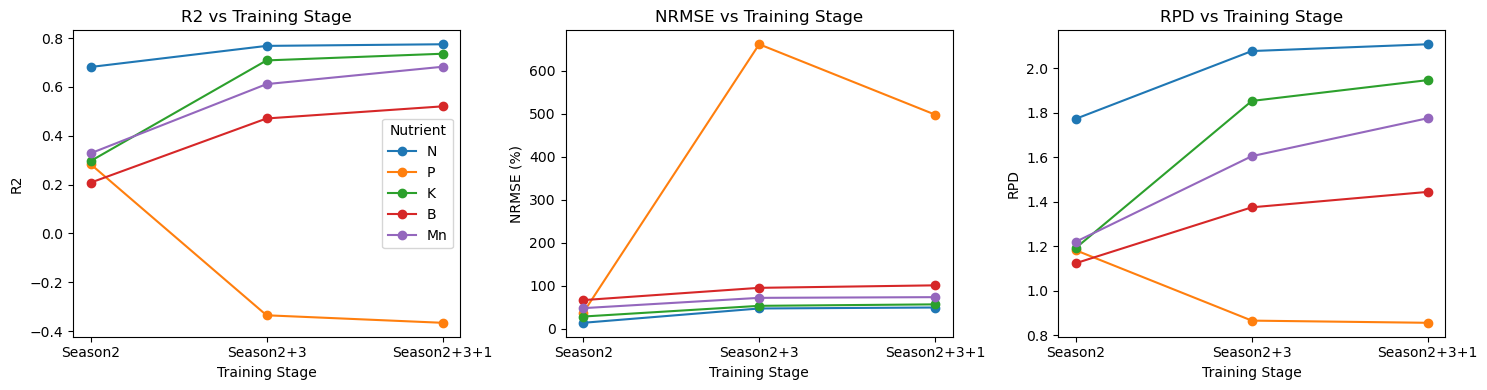

In [30]:
# Pivot the performance results for readability (e.g., R² by stage and nutrient)
performance_pivot = performance_df.pivot(index="Stage", columns="Nutrient", values="R2")
print("R² of Stacked Model by Stage (Rows) and Nutrient (Cols):")
print(performance_pivot.round(3))

# Save full performance metrics to CSV
performance_df.to_csv("nutrient_model_performance.csv", index=False)
print("\nFull performance metrics saved to 'nutrient_model_performance.csv'.")

# Plot performance evolution across stages for each metric
metrics = ["R2", "NRMSE", "RPD"]
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, metric in enumerate(metrics):
    ax = axes[i]
    for nutrient in target_nutrients:
        vals = performance_df[performance_df["Nutrient"]==nutrient].set_index("Stage")[metric]
        ax.plot(vals.index, vals.values, marker='o', label=nutrient)
    ax.set_title(f"{metric} vs Training Stage")
    ax.set_xlabel("Training Stage"); 
    ax.set_ylabel(metric + (" (%)" if metric=="NRMSE" else ""))
    if metric == "R2":
        ax.legend(title="Nutrient")
plt.tight_layout()
plt.show()